# 方法2: matplotlib で手動描画

**カスタマイズが必要な場合の方法** - 自分でフィールドを描く

| メリット | デメリット |
|----------|------------|
| ヒートマップ（kdeplot）との組み合わせが容易 | コードが多い |
| 完全なカスタマイズが可能 | 座標変換の理解が必要 |
| 色やスタイルを自由に変更 | |

---

In [1]:
!pip install pybaseball duckdb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.6 MB/s eta 0:00:00


In [2]:
from pybaseball import statcast
import duckdb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

## 1. Statcast座標系の理解（重要）

**Statcastの座標系:**
- ホームプレート位置: `(125.42, 198.27)`
- Y軸は画面座標系（上がゼロ、下が大きい）→ 通常の数学座標系とは逆

**変換式:**
```python
x = 2.5 * (hc_x - 125.42)  # ホームプレートを原点に
y = 2.5 * (198.27 - hc_y)  # Y軸を反転
```

係数2.5でおおよそフィート単位に変換

# 2025年シーズンのStatcastデータ取得
df = statcast(start_dt='2025-03-01', end_dt='2025-12-31')
print(f"Total records: {len(df):,}")

In [ ]:
# ====== 設定 ======
BATTER_ID = 660271      # 大谷翔平 MLBAM ID
SEASON_YEAR = 2025
GAME_TYPE = "R"         # "R"=レギュラーシーズン, "P"=ポストシーズン, None=全試合
# ==================

# Statcastデータ取得
df_raw = statcast(start_dt=f'{SEASON_YEAR}-03-01', end_dt=f'{SEASON_YEAR}-12-31')
print(f"Total records (raw): {len(df_raw):,}")

# game_typeでフィルタ
con = duckdb.connect()
if GAME_TYPE:
    df = con.execute(f"""
        SELECT * FROM df_raw WHERE game_type = '{GAME_TYPE}'
    """).df()
    print(f"Filtered records (game_type='{GAME_TYPE}'): {len(df):,}")
else:
    df = df_raw.copy()
    print(f"Using all game types: {len(df):,}")

In [4]:
# 大谷のヒットとアウトを抽出
df_hits = con.execute("""
    SELECT * FROM df
    WHERE batter = 660271
      AND events IN ('home_run', 'double', 'triple', 'single')
      AND hc_x IS NOT NULL AND hc_y IS NOT NULL
""").df()

df_outs = con.execute("""
    SELECT * FROM df
    WHERE batter = 660271
      AND events NOT IN ('home_run', 'double', 'triple', 'single')
      AND hc_x IS NOT NULL AND hc_y IS NOT NULL
""").df()

print(f"Hits: {len(df_hits)}, Outs: {len(df_outs)}")

Hits: 172, Outs: 254


## 3. 座標変換関数

In [5]:
def transform_statcast_coords(df):
    """Statcast座標を標準的な野球場座標に変換

    変換後:
    - ホームプレートが原点(0, 0)
    - Y軸が外野方向に増加
    - 単位はおおよそフィート
    """
    df = df.copy()
    df['x'] = 2.5 * (df['hc_x'] - 125.42)
    df['y'] = 2.5 * (198.27 - df['hc_y'])
    return df

df_hits_t = transform_statcast_coords(df_hits)
df_outs_t = transform_statcast_coords(df_outs)

---
## 4. フィールド描画関数（ファールゾーン含む）

**描画する要素:**
- ファールライン（2本の直線）
- 内野アーク
- 外野フェンス
- ベースパス（ダイヤモンド）
- ベースマーカー
- ピッチャーマウンド

In [6]:
def draw_baseball_field(ax, foul_distance=330, outfield_distance=340):
    """野球場を描画（ホームプレートが原点）

    Args:
        ax: matplotlib axes
        foul_distance: ファールラインの長さ（フィート）
        outfield_distance: 外野フェンスまでの距離（フィート）
    """

    # ファールライン（45度の角度で外野へ）
    ax.plot([0, -foul_distance * 0.707], [0, foul_distance * 0.707],
            'k-', lw=2, label='Foul Line')
    ax.plot([0, foul_distance * 0.707], [0, foul_distance * 0.707],
            'k-', lw=2)

    # 内野アーク（約95フィート）
    theta = np.linspace(-np.pi/4, np.pi/4, 100)
    infield_dist = 95
    ax.plot(infield_dist * np.sin(theta), infield_dist * np.cos(theta),
            'green', lw=2, alpha=0.7, label='Infield')

    # 外野フェンス
    ax.plot(outfield_distance * np.sin(theta), outfield_distance * np.cos(theta),
            'saddlebrown', lw=3, alpha=0.7, label='Outfield Fence')

    # ベースパス（90フィート四方のダイヤモンド）
    bases_x = [0, 63.64, 0, -63.64, 0]
    bases_y = [0, 63.64, 127.28, 63.64, 0]
    ax.plot(bases_x, bases_y, 'k-', lw=1.5)

    # ベースのマーカー
    ax.scatter([0], [0], color='white', edgecolors='black', s=150, marker='p', zorder=5)
    ax.scatter([63.64, 0, -63.64], [63.64, 127.28, 63.64],
               color='white', edgecolors='black', s=100, marker='s', zorder=5)

    # ピッチャーマウンド（60.5フィート）
    ax.scatter([0], [60.5], color='brown', s=80, zorder=5)

    ax.set_aspect('equal')
    ax.set_facecolor('lightgreen')

    return ax

---
## 5. 散布図版

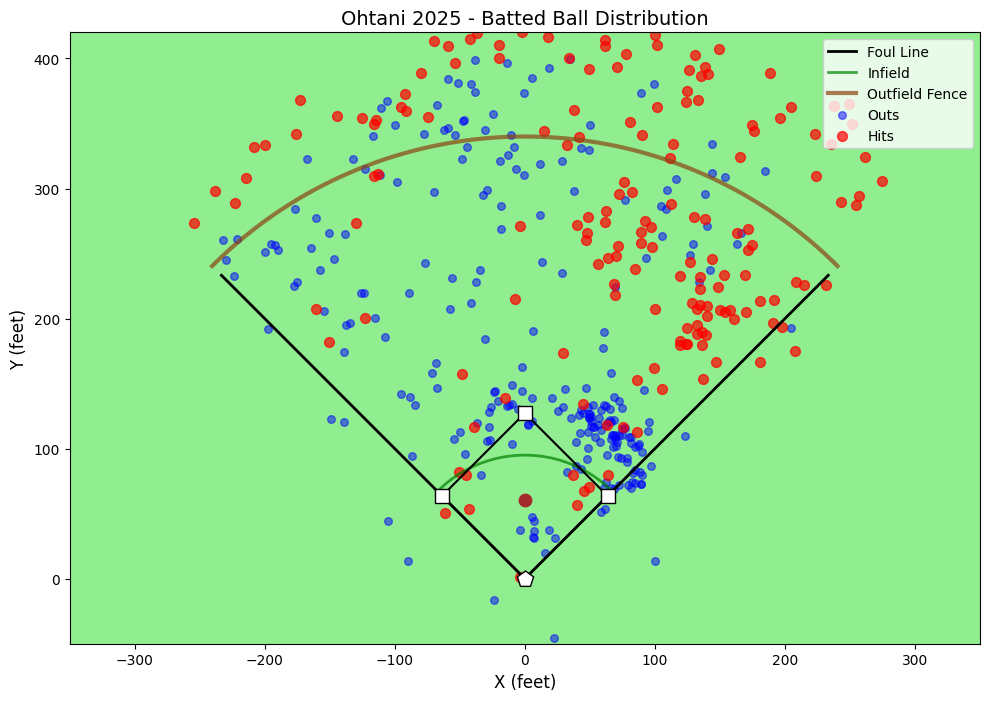

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

draw_baseball_field(ax)

ax.scatter(df_outs_t['x'], df_outs_t['y'], c='blue', alpha=0.5, s=30, label='Outs')
ax.scatter(df_hits_t['x'], df_hits_t['y'], c='red', alpha=0.7, s=50, label='Hits')

ax.set_xlim(-350, 350)
ax.set_ylim(-50, 420)
ax.set_xlabel('X (feet)', fontsize=12)
ax.set_ylabel('Y (feet)', fontsize=12)
ax.set_title('Ohtani 2025 - Batted Ball Distribution', fontsize=14)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

---
## 6. ヒートマップ版（seaborn.kdeplot）

**matplotlib手動描画の最大のメリット** - ヒートマップとの組み合わせが容易

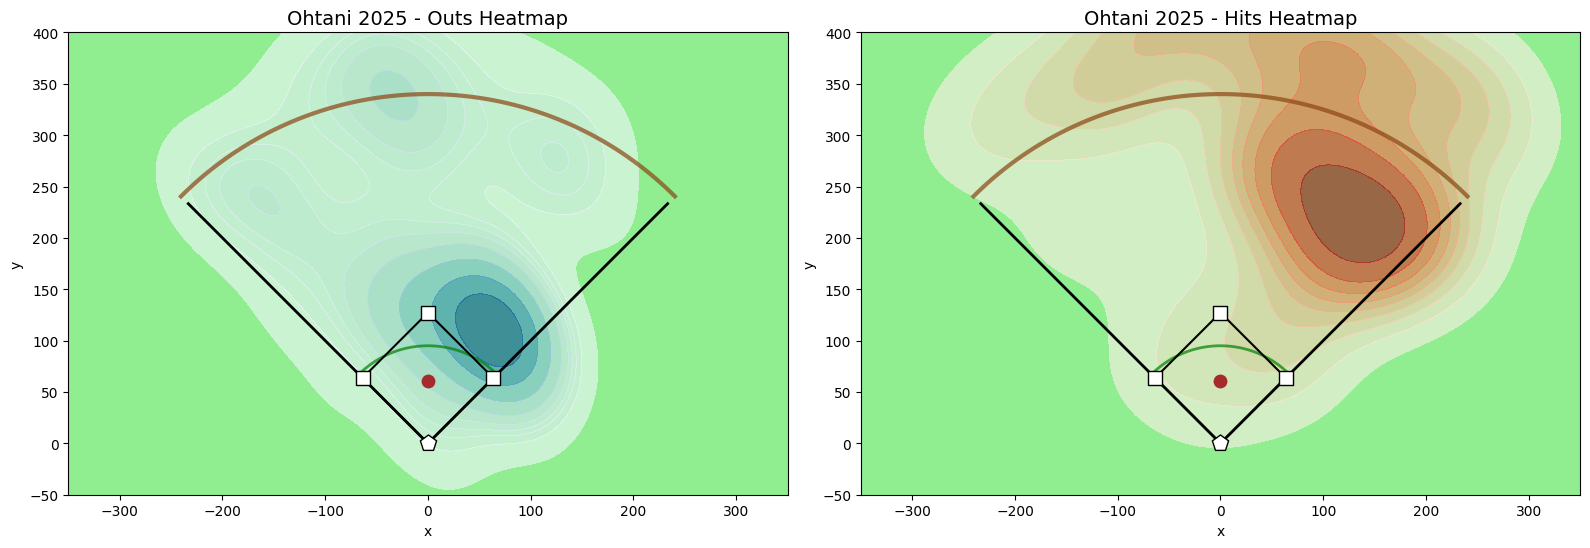

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Outs ヒートマップ
draw_baseball_field(axs[0])
sns.kdeplot(data=df_outs_t, x='x', y='y', ax=axs[0],
            cmap='Blues', fill=True, alpha=0.6, levels=10)
axs[0].set_xlim(-350, 350)
axs[0].set_ylim(-50, 400)
axs[0].set_title('Ohtani 2025 - Outs Heatmap', fontsize=14)

# Hits ヒートマップ
draw_baseball_field(axs[1])
sns.kdeplot(data=df_hits_t, x='x', y='y', ax=axs[1],
            cmap='Reds', fill=True, alpha=0.6, levels=10)
axs[1].set_xlim(-350, 350)
axs[1].set_ylim(-50, 400)
axs[1].set_title('Ohtani 2025 - Hits Heatmap', fontsize=14)

plt.tight_layout()
plt.show()

## 7. ヒストグラム版（seaborn.histplot）

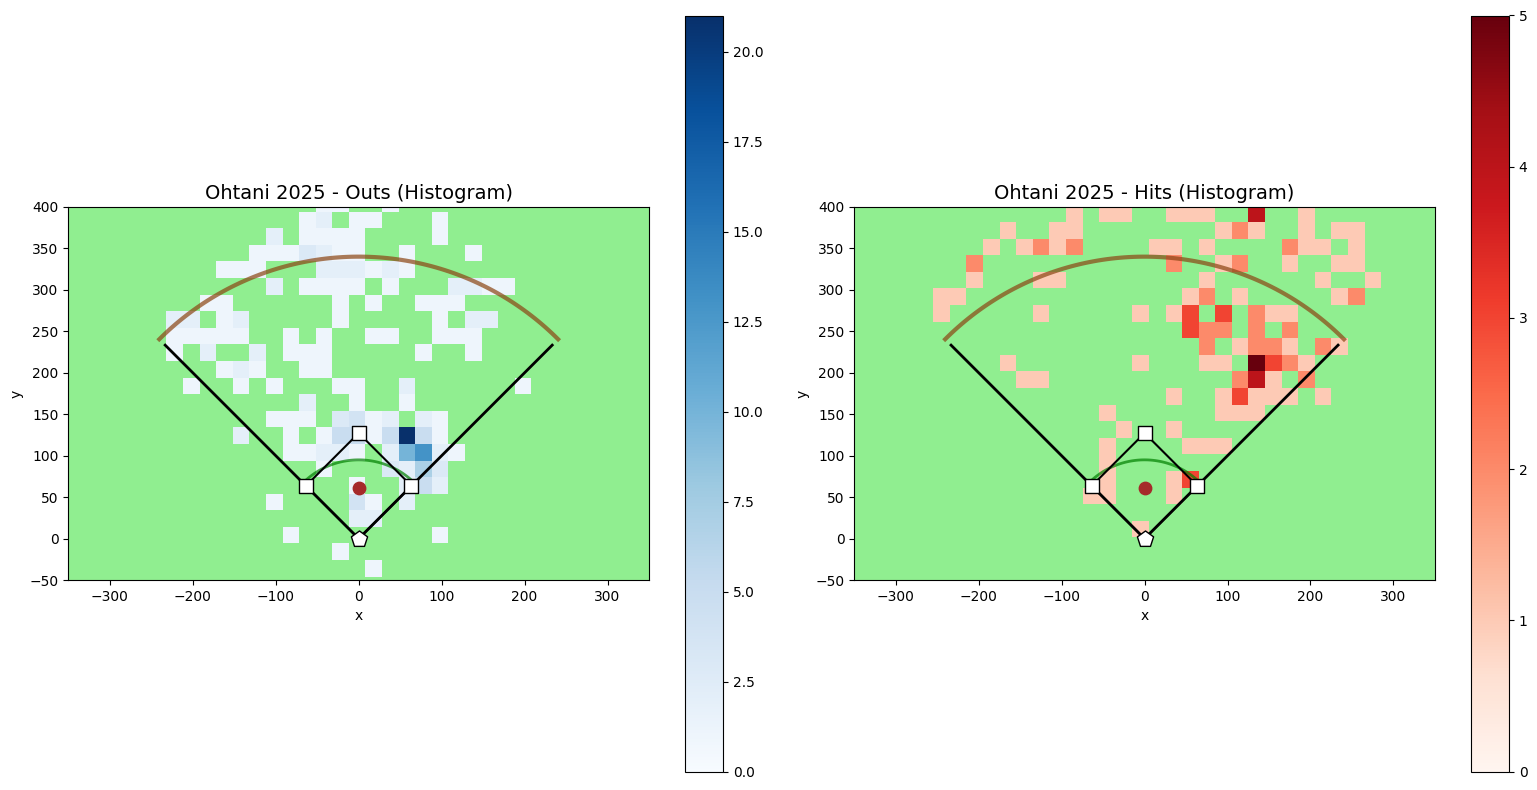

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

draw_baseball_field(axs[0])
sns.histplot(data=df_outs_t, x='x', y='y', ax=axs[0], cmap='Blues', cbar=True, binwidth=20)
axs[0].set_xlim(-350, 350)
axs[0].set_ylim(-50, 400)
axs[0].set_title('Ohtani 2025 - Outs (Histogram)', fontsize=14)

draw_baseball_field(axs[1])
sns.histplot(data=df_hits_t, x='x', y='y', ax=axs[1], cmap='Reds', cbar=True, binwidth=20)
axs[1].set_xlim(-350, 350)
axs[1].set_ylim(-50, 400)
axs[1].set_title('Ohtani 2025 - Hits (Histogram)', fontsize=14)

plt.tight_layout()
plt.show()

## 8. イベント別カラーマップ

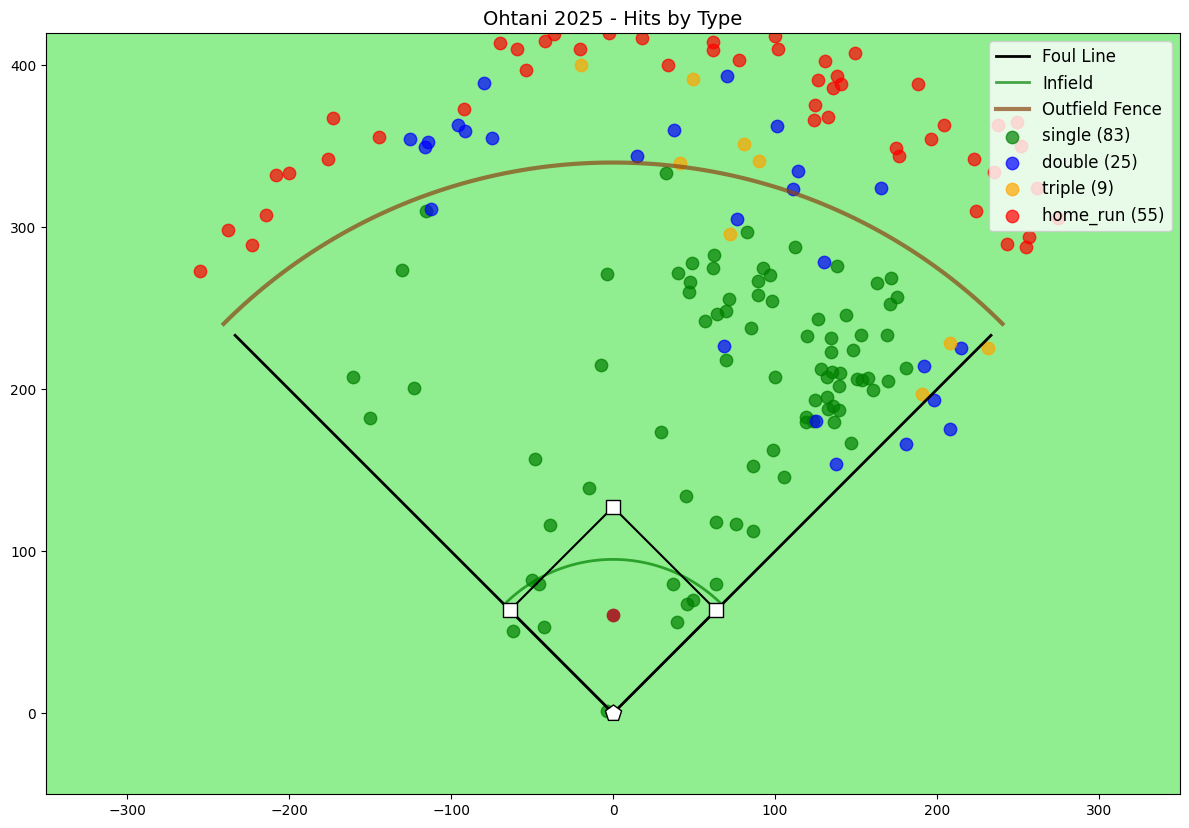

In [10]:
colors = {
    'single': 'green',
    'double': 'blue',
    'triple': 'orange',
    'home_run': 'red'
}

fig, ax = plt.subplots(figsize=(12, 12))
draw_baseball_field(ax)

for event, color in colors.items():
    subset = df_hits_t[df_hits_t['events'] == event]
    ax.scatter(subset['x'], subset['y'], c=color, alpha=0.7,
               s=80, label=f"{event} ({len(subset)})")

ax.set_xlim(-350, 350)
ax.set_ylim(-50, 420)
ax.set_title('Ohtani 2025 - Hits by Type', fontsize=14)
ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

---
## まとめ

**matplotlib手動描画のポイント:**

1. **座標変換が必須**
```python
x = 2.5 * (hc_x - 125.42)
y = 2.5 * (198.27 - hc_y)
```

2. **フィールドの描画要素**
   - ファールライン: `ax.plot()` で2本の直線
   - 外野フェンス: `np.sin/cos` でアーク描画
   - ダイヤモンド: 4点を結ぶ線

3. **ヒートマップとの組み合わせ**
```python
draw_baseball_field(ax)
sns.kdeplot(data=df, x='x', y='y', ax=ax, cmap='Reds', fill=True)
```